In [5]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
session = "linear_regression_act_only"
runs = api.runs(f"tony_t_liu/{session}")


meta_data = {
    "batch_size": [],
    "act_man_width": [],
    "weight_man_width": [],
}

stat_data = {
    "lr": [],
    "test_acc": [],
    "test_loss": [],
    "grad_norm_entire": [],
    "grad_norm_entire_ema": [],
}

for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    for key in stat_data:
        if key in run.summary._json_dict:
            stat_data[key].append(run.summary._json_dict[key])
        else:
            stat_data[key].append(None)

    for key in meta_data:
        if key in run.config:
            meta_data[key].append(run.config[key])
        else:
            meta_data[key].append(None)

runs_df = pd.DataFrame(meta_data | stat_data)


In [6]:
# pad none id with empty string
runs_df


,batch_size,act_man_width,weight_man_width,lr,test_acc,test_loss,grad_norm_entire,grad_norm_entire_ema
0,1600,0,23,0.003,0,0.402510,0.091333,0.091352
1,1600,0,23,0.003,0,0.402546,0.091333,0.092033
2,1600,0,23,0.003,0,0.402276,0.091333,0.091353
3,1600,0,23,0.003,0,0.402619,0.091333,0.091359
4,1600,0,23,0.003,0,0.402458,0.091333,0.091351
...,...,...,...,...,...,...,...,...
315,2,23,23,0.003,0,0.422373,0.042216,0.078345
316,2,23,23,0.003,0,0.420294,0.029967,0.046783
317,2,23,23,0.003,0,0.417359,0.045379,0.063809
318,2,23,23,0.003,0,0.417041,0.060584,0.074180


In [7]:
# runs_df.dropna(subset=["group"], inplace=True)
# runs_df["id"] = runs_df["id"].fillna("")
# runs_df["method"] = "stochastic"
# runs_df.loc[runs_df["id"].str.contains("nearest"), "method"] = "nearest"
# runs_df.drop(columns=["group", "id"], inplace=True)
runs_df

,batch_size,act_man_width,weight_man_width,lr,test_acc,test_loss,grad_norm_entire,grad_norm_entire_ema
0,1600,0,23,0.003,0,0.402510,0.091333,0.091352
1,1600,0,23,0.003,0,0.402546,0.091333,0.092033
2,1600,0,23,0.003,0,0.402276,0.091333,0.091353
3,1600,0,23,0.003,0,0.402619,0.091333,0.091359
4,1600,0,23,0.003,0,0.402458,0.091333,0.091351
...,...,...,...,...,...,...,...,...
315,2,23,23,0.003,0,0.422373,0.042216,0.078345
316,2,23,23,0.003,0,0.420294,0.029967,0.046783
317,2,23,23,0.003,0,0.417359,0.045379,0.063809
318,2,23,23,0.003,0,0.417041,0.060584,0.074180


In [8]:
#runs_df = runs_df.groupby(["batch_size", "weight_man_width", "act_man_width", "method", "lr"]).mean().reset_index()
runs_df = runs_df.groupby(["batch_size", "weight_man_width", "act_man_width", "lr"]).mean().reset_index()
import numpy as np
runs_df["lr"] = runs_df["lr"].astype(np.float32)
runs_df.to_csv(f"../out/result_tables/{session}.csv")

In [5]:
runs_df

,batch_size,weight_man_width,act_man_width,lr,test_acc,test_loss,grad_norm_entire,grad_norm_entire_ema
0,32,0,0,0.03,0.103375,2.357775,0.000000e+00,4.537500e-06
1,32,1,1,0.03,0.114500,2.346650,0.000000e+00,2.829065e-04
2,32,2,2,0.03,0.142750,2.318400,0.000000e+00,4.683310e-05
3,32,4,4,0.03,0.096375,2.364775,0.000000e+00,3.249370e-04
4,32,8,8,0.03,0.120750,2.340400,0.000000e+00,3.784675e-04
5,32,16,16,0.03,0.116500,2.344650,3.067750e-15,1.386621e-04
6,32,23,23,0.03,0.135875,2.325275,0.000000e+00,2.459538e-04
7,64,0,0,0.03,0.102250,2.358900,0.000000e+00,1.668323e-07
8,64,1,1,0.03,0.108250,2.352900,0.000000e+00,1.851799e-03
9,64,2,2,0.03,0.466750,1.994381,1.083932e-01,1.561348e-01


In [26]:
runs_df["lr"].unique()

array([0.03], dtype=float32)

In [37]:
# runs_df.dropna(subset=["group"], inplace=True)
# runs_df["id"] = runs_df["id"].fillna("")
# runs_df["method"] = "stochastic"
# runs_df.loc[runs_df["id"].str.contains("nearest"), "method"] = "nearest"
# runs_df.drop(columns=["group", "id"], inplace=True)
# runs_df = runs_df.groupby(["batch_size", "man_width", "method", "lr"]).mean().reset_index()
# import numpy as np
# runs_df["lr"] = runs_df["lr"].astype(np.float32)
# runs_df.to_csv(f"{session}.csv")

In [13]:
runs_df_m = runs_df
runs_df_m["grad_norm_entire_ema"][runs_df_m["test_loss"] > 1.5] = 0.1

/tmp/ipykernel_1437529/3703247604.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  runs_df_m["grad_norm_entire_ema"][runs_df_m["test_loss"] > 1.5] = 0.1
/tmp/ipykernel_1437529/3703247604.py:2: SettingWithCopyWarning: 
A value is trying to

In [14]:
import pandas as pd
import numpy as np
import matplotlib.backends
%matplotlib inline 
import matplotlib.pyplot as plt


def make_plot(df, dir, levels=10):
    # df = df.drop(columns=["method"])
    grouped_df = df.groupby(['act_man_width', 'batch_size']).mean().reset_index()
    df_avg = grouped_df
    # Pivot the data to create a grid for the contour plot
    pivot_table = df_avg.pivot_table(index='batch_size', columns='act_man_width', values='grad_norm_entire_ema')

    # Create a meshgrid for the contour plot
    X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)
    Z = pivot_table.values

    print(pivot_table.shape)
    print(pivot_table)

    # Pad the surrounding of Z with the same value as the edge (pad on the beginning side)
    Z = np.pad(Z, ((1, 0), (1, 0)), mode='edge')
    print(X.shape, Y.shape, Z.shape)

    # Update meshgrid to match the padded Z
    X, Y = np.meshgrid(
        np.insert(pivot_table.columns, 0, pivot_table.columns[0] - 1), 
        np.insert(pivot_table.index, 0, pivot_table.index[0] - 1)
    )

    # Create a 2D contour plot
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(X, Y, Z, levels=levels)
    plt.colorbar(cp, label='Norm')

    # Set the y-axis to log scale if needed
    # plt.yscale('log')  # Uncomment this line if the y-axis should be in log scale

    # Labeling the axes
    plt.xlabel('Mantissa Width')
    plt.ylabel('Batch Size')
    lr = df['lr'].iloc[0]
    plt.savefig(f"{dir}/{lr}.png")


In [11]:
# runs_df = pd.read_csv("../out/result_tables/c.csv")

(3, 7)
act_man_width   0    1         2         4         8         16        23
batch_size                                                               
32             0.1  0.1  0.100000  0.100000  0.100000  0.100000  0.100000
64             0.1  0.1  0.100000  0.012138  0.008908  0.003821  0.005264
128            0.1  0.1  0.105189  0.006994  0.005575  0.003921  0.004981
(3, 7) (3, 7) (4, 8)


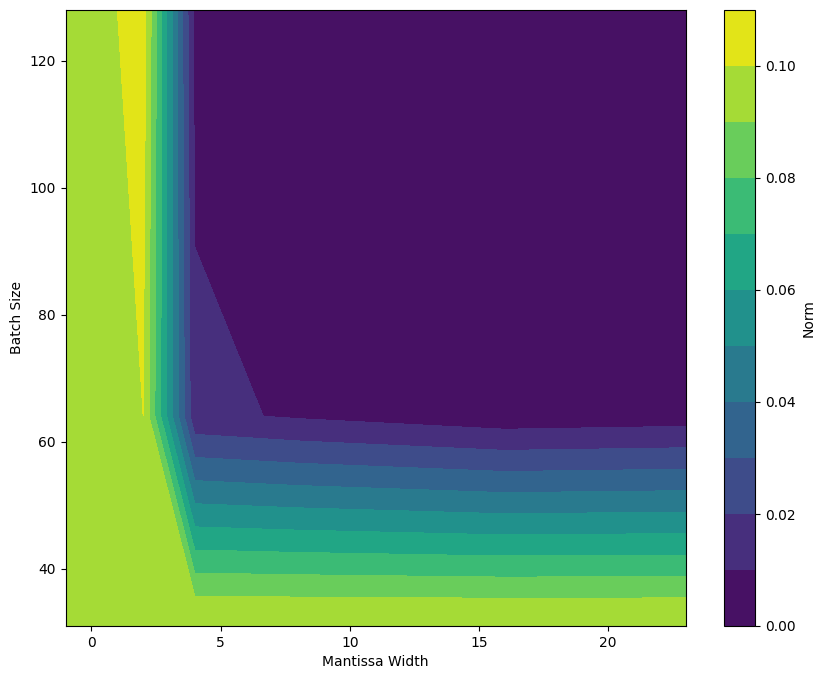

In [15]:
make_plot(runs_df_m, "../out/result_images/mnist_cnn")


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def line_plot(df, dir):
    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.plot(df['batch_size'], df['grad_norm_entire'], marker='o', linestyle='-', color='b')

    # Adding labels and title
    plt.xlabel('Batch Size')
    plt.ylabel('Average Gradient Norm')
    plt.title('Gradient Norm vs. Batch Size for Mantissa Width 1')
    plt.grid(True)

    # Optionally, set the x-axis to log scale if the batch sizes are not uniformly distributed
    # plt.xscale('log')

    # Save the plot
    lr = df['lr'].iloc[0]  # Assuming learning rate 'lr' is constant across the DataFrame
    plt.savefig(f"{dir}/gradient_norm_vs_batch_size_{lr}.png")

    # Show the plot if you are running this in an interactive environment (optional)
    plt.show()


In [29]:
runs_df

,batch_size,weight_man_width,act_man_width,lr,test_acc,test_loss,grad_norm_entire,grad_norm_entire_ema
0,1,0,0,0.03,0.932917,0.169003,0.021467,0.026696
1,1,1,1,0.03,0.933333,0.167431,0.012417,0.022605
2,1,2,2,0.03,0.932917,0.171338,0.010602,0.020213
3,1,23,0,0.03,0.933333,0.171372,0.015566,0.024971
4,1,23,1,0.03,0.933750,0.171188,0.012642,0.021469
...,...,...,...,...,...,...,...,...
58,2800,2,2,0.03,0.589167,34.841064,0.038989,0.039007
59,2800,23,0,0.03,0.587083,34.906601,0.039658,0.039625
60,2800,23,1,0.03,0.587083,34.902054,0.039487,0.039457
61,2800,23,2,0.03,0.587917,34.962962,0.038840,0.038737


In [30]:
base_line = runs_df[(runs_df["weight_man_width"] == 23) & (runs_df["act_man_width"] == 23)]
base_line

,batch_size,weight_man_width,act_man_width,lr,test_acc,test_loss,grad_norm_entire,grad_norm_entire_ema
6,1,23,23,0.03,0.933750,0.170995,0.013020,0.020063
13,10,23,23,0.03,0.933333,0.170909,0.001405,0.001157
20,50,23,23,0.03,0.933333,0.170886,0.000932,0.000874
27,100,23,23,0.03,0.933333,0.170898,0.000861,0.000852
34,300,23,23,0.03,0.933333,0.170657,0.001174,0.001141
41,500,23,23,0.03,0.933333,0.170541,0.000579,0.000574
48,700,23,23,0.03,0.933333,0.170898,0.000834,0.000836
55,1400,23,23,0.03,0.933333,0.170900,0.000837,0.000839
62,2800,23,23,0.03,0.668125,13.984344,0.152764,0.153092


In [17]:
runs_df = pd.read_csv("../out/result_tables/large_batch_size_activation_quant_only.csv")

In [18]:
runs_df = runs_df[runs_df["batch_size"] <= 700]

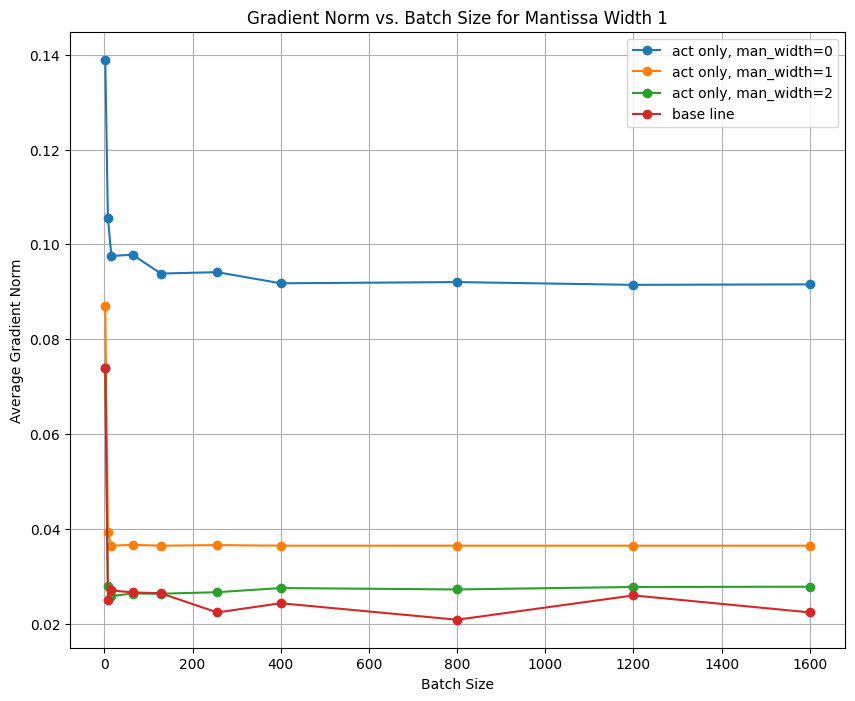

: 

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Loop through each man_width and plot lines for both data frames
for man_width in [0, 1, 2]:
    actlow = runs_df[(runs_df["act_man_width"] == man_width) & (runs_df["weight_man_width"] == 23)]
    # bothlow = runs_df[(runs_df["act_man_width"] == man_width) & (runs_df["weight_man_width"] == man_width)]
    
    plt.plot(actlow['batch_size'], actlow['grad_norm_entire_ema'], marker='o', linestyle='-', label=f"act only, man_width={man_width}")
    # plt.plot(bothlow['batch_size'], bothlow['grad_norm_entire_ema'], marker='o', linestyle='-', label=f"act weight, mam_width={man_width}")

base_line = runs_df[(runs_df["weight_man_width"] == 23) & (runs_df["act_man_width"] == 23)]
plt.plot(base_line['batch_size'], base_line['grad_norm_entire_ema'], marker='o', linestyle='-', label='base line')


# Adding labels and title
plt.xlabel('Batch Size')
plt.ylabel('Average Gradient Norm')
plt.title('Gradient Norm vs. Batch Size for Mantissa Width 1')
plt.grid(True)

# Adding the legend
plt.legend()

# Optionally, set the x-axis to log scale if the batch sizes are not uniformly distributed
# plt.xscale('log')

plt.show()
